In [2866]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from math import radians, cos, sin, asin, sqrt
from fancyimpute import KNN
from scipy.stats import chi2_contingency
from datetime import datetime, timedelta 
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, r2_score, mean_absolute_error,mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.externals import joblib
%matplotlib inline

In [2867]:
#change working directory
os.chdir(r"C:\Users\M1053735\Pictures\Cab_Fare_pred")
print(os.getcwd())

C:\Users\M1053735\Pictures\Cab_Fare_pred


In [2868]:
#Reading the Data
train_df = pd.read_csv("train_cab.csv")
test_df = pd.read_csv("test.csv")

# Exploring The Data

In [2869]:
train_df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1.0
1,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1.0
2,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2.0
3,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1.0
4,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1.0


In [2870]:
test_df.head()

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24 UTC,-73.973320,40.763805,-73.981430,40.743835,1
1,2015-01-27 13:08:24 UTC,-73.986862,40.719383,-73.998886,40.739201,1
2,2011-10-08 11:53:44 UTC,-73.982524,40.751260,-73.979654,40.746139,1
3,2012-12-01 21:12:12 UTC,-73.981160,40.767807,-73.990448,40.751635,1
4,2012-12-01 21:12:12 UTC,-73.966046,40.789775,-73.988565,40.744427,1



The details of data attributes in the dataset are as follows:

    pickup_datetime - timestamp value indicating when the cab ride started.
    pickup_longitude - float for longitude coordinate of where the cab ride started.
    pickup_latitude - float for latitude coordinate of where the cab ride started.
    dropoff_longitude - float for longitude coordinate of where the cab ride ended.
    dropoff_latitude - float for latitude coordinate of where the cab ride ended.
    passenger_count - an integer indicating the number of passengers in the cab ride.


In [2871]:
train_df.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,16067.000000,16067.000000,16067.000000,16067.000000,16012.000000
mean,-72.462787,39.914725,-72.462328,39.897906,2.625070
std,10.578384,6.826587,10.575062,6.187087,60.844122
min,-74.438233,-74.006893,-74.429332,-74.006377,0.000000
25%,-73.992156,40.734927,-73.991182,40.734651,1.000000
50%,-73.981698,40.752603,-73.980172,40.753567,1.000000
75%,-73.966838,40.767381,-73.963643,40.768013,2.000000
max,40.766125,401.083332,40.802437,41.366138,5345.000000


In [2872]:
test_df.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000
mean,-73.974722,40.751041,-73.973657,40.751743,1.671273
std,0.042774,0.033541,0.039072,0.035435,1.278747
min,-74.252193,40.573143,-74.263242,40.568973,1.000000
25%,-73.992501,40.736125,-73.991247,40.735254,1.000000
50%,-73.982326,40.753051,-73.980015,40.754065,1.000000
75%,-73.968013,40.767113,-73.964059,40.768757,2.000000
max,-72.986532,41.709555,-72.990963,41.696683,6.000000


#### clearly we can see that there are anomalies in the dataset. std and max value of passenger_count of train_df is not normal

In [2873]:
print("shape of training data is: ",train_df.shape) #checking the number of rows and columns in training data
print("shape of test data is: ",test_df.shape) #checking the number of rows and columns in test data

shape of training data is:  (16067, 7)
shape of test data is:  (9914, 6)


In [2874]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16067 entries, 0 to 16066
Data columns (total 7 columns):
fare_amount          16043 non-null object
pickup_datetime      16067 non-null object
pickup_longitude     16067 non-null float64
pickup_latitude      16067 non-null float64
dropoff_longitude    16067 non-null float64
dropoff_latitude     16067 non-null float64
passenger_count      16012 non-null float64
dtypes: float64(5), object(2)
memory usage: 878.7+ KB


In [2875]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9914 entries, 0 to 9913
Data columns (total 6 columns):
pickup_datetime      9914 non-null object
pickup_longitude     9914 non-null float64
pickup_latitude      9914 non-null float64
dropoff_longitude    9914 non-null float64
dropoff_latitude     9914 non-null float64
passenger_count      9914 non-null int64
dtypes: float64(4), int64(1), object(1)
memory usage: 464.8+ KB


#### Here we can see that pickup_datetime and fare_amount are object and passenger_count is float. we need to do proper conversion.

In [2876]:
#DateTime Conversion
#an error has ben raised it means that there are date string values which are not likely a datetime
train_df['pickup_datetime'] = pd.to_datetime(train_df['pickup_datetime'],errors='coerce') # if such values occurs replace it with NaT

In [2877]:
train_df['fare_amount'] = pd.to_numeric(train_df['fare_amount'], errors='coerce')
#train_df['passenger_count'] = pd.to_numeric(train_df['passenger_count'], downcast='integer',errors='coerce')
test_df['pickup_datetime'] = pd.to_datetime(test_df['pickup_datetime'],errors='coerce')

In [2878]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9914 entries, 0 to 9913
Data columns (total 6 columns):
pickup_datetime      9914 non-null datetime64[ns, UTC]
pickup_longitude     9914 non-null float64
pickup_latitude      9914 non-null float64
dropoff_longitude    9914 non-null float64
dropoff_latitude     9914 non-null float64
passenger_count      9914 non-null int64
dtypes: datetime64[ns, UTC](1), float64(4), int64(1)
memory usage: 464.8 KB


In [2879]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16067 entries, 0 to 16066
Data columns (total 7 columns):
fare_amount          16042 non-null float64
pickup_datetime      16066 non-null datetime64[ns, UTC]
pickup_longitude     16067 non-null float64
pickup_latitude      16067 non-null float64
dropoff_longitude    16067 non-null float64
dropoff_latitude     16067 non-null float64
passenger_count      16012 non-null float64
dtypes: datetime64[ns, UTC](1), float64(6)
memory usage: 878.7 KB


In [2880]:
print(train_df['passenger_count'].value_counts())
print(test_df['passenger_count'].value_counts())

1.00       11259
2.00        2322
5.00        1045
3.00         676
4.00         329
6.00         302
0.00          57
43.00          2
53.00          2
0.12           1
1.30           1
531.20         1
345.00         1
456.00         1
87.00          1
55.00          1
58.00          1
236.00         1
535.00         1
536.00         1
537.00         1
554.00         1
5334.00        1
35.00          1
5345.00        1
557.00         1
354.00         1
Name: passenger_count, dtype: int64
1    6914
2    1474
5     696
3     447
4     206
6     177
Name: passenger_count, dtype: int64


#### as we can see that passenger_count can have 1-6 values all other consider to be outliers

In [2881]:
train_df['fare_amount'].sort_values(ascending=False)

1015     54343.00
1072      4343.00
607        453.00
980        434.00
1335       180.00
1483       165.00
6630       128.83
14142      108.00
12349      104.67
12915       96.00
7810        95.00
9431        88.00
10077       87.30
12614       87.00
4620        85.50
14519       82.50
12437       80.75
2639        79.00
4013        77.70
13962       77.15
2013        77.00
6668        76.80
8363        76.00
10524       75.80
11019       75.33
13615       75.00
15023       73.30
1494        70.00
4118        69.70
649         66.30
           ...   
2780         0.01
10002        0.00
2486        -2.50
2039        -2.90
13032       -3.00
8             NaN
26            NaN
69            NaN
126           NaN
168           NaN
240           NaN
305           NaN
350           NaN
413           NaN
455           NaN
498           NaN
667           NaN
703           NaN
746           NaN
836           NaN
840           NaN
913           NaN
1123          NaN
1574          NaN
1628      

#### as we can see that fare_amount conatins nan as well as negative values

In [2882]:
train_df.describe() #check the min, max, mean, std of fare_amount
#It turns out min and max value are outliers and as we can see they are affecting the std which is 430.46 considering 25%,50%,75% of data have lower values.

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,16042.000000,16067.000000,16067.000000,16067.000000,16067.000000,16012.000000
mean,15.015004,-72.462787,39.914725,-72.462328,39.897906,2.625070
std,430.460945,10.578384,6.826587,10.575062,6.187087,60.844122
min,-3.000000,-74.438233,-74.006893,-74.429332,-74.006377,0.000000
25%,6.000000,-73.992156,40.734927,-73.991182,40.734651,1.000000
50%,8.500000,-73.981698,40.752603,-73.980172,40.753567,1.000000
75%,12.500000,-73.966838,40.767381,-73.963643,40.768013,2.000000
max,54343.000000,40.766125,401.083332,40.802437,41.366138,5345.000000


In [2883]:
print('above 180 =>',sum(train_df['fare_amount']>180))# only 4 observations out of 16042.
print('above 453 =>',sum(train_df['fare_amount']>453))#only 2 observation out of 16042. so we can say that fare_amount above 453 are outliers
print('0 =>', sum(train_df['fare_amount']==0))#fare cannot be zero

above 180 => 4
above 453 => 2
0 => 1


In [2884]:
# fare_amount cannot be less than 1 and the passenger_count ranges from 1-6 because its a cab.
(sum(train_df['fare_amount']<1),sum(train_df['passenger_count']>6),sum(train_df['passenger_count']<1))

(5, 20, 58)

In [2885]:
# Latitudes range from -90 to 90, and longitudes range from -180 to 180.
print('----------------Train---------------')
print('pickup_latitude above 90 in train data ={}'.format(sum(train_df['pickup_latitude']>90)))
print('pickup_latitude below -90 in train data ={}'.format(sum(train_df['pickup_latitude']<-90)))
print('pickup_longitude above 180 in train data ={}'.format(sum(train_df['pickup_longitude']>180)))
print('pickup_longitude below -180 in train data ={}'.format(sum(train_df['pickup_longitude']<-180)))
print('dropoff_latitude above 90 in train data={}'.format(sum(train_df['dropoff_latitude']>90)))
print('dropoff_latitude below -90 in train data={}'.format(sum(train_df['dropoff_latitude']<-90)))
print('dropoff_longitude above 180 in train data={}'.format(sum(train_df['dropoff_longitude']>180)))
print('dropoff_longitude below -180 in train data={}'.format(sum(train_df['dropoff_longitude']<-180)))
print('----------------Test---------------')
print('pickup_latitude above 90 in test data ={}'.format(sum(test_df['pickup_latitude']>90)))
print('pickup_latitude below -90 in test data ={}'.format(sum(test_df['pickup_latitude']<-90)))
print('pickup_longitude above 180 in test data ={}'.format(sum(test_df['pickup_longitude']>180)))
print('pickup_longitude below -180 in test data ={}'.format(sum(test_df['pickup_longitude']<-180)))
print('dropoff_latitude above 90 in test data={}'.format(sum(test_df['dropoff_latitude']>90)))
print('dropoff_latitude below -90 in test data={}'.format(sum(test_df['dropoff_latitude']<-90)))
print('dropoff_longitude above 180 in test data={}'.format(sum(test_df['dropoff_longitude']>180)))
print('dropoff_longitude below -180 in test data={}'.format(sum(test_df['dropoff_longitude']<-180)))




----------------Train---------------
pickup_latitude above 90 in train data =1
pickup_latitude below -90 in train data =0
pickup_longitude above 180 in train data =0
pickup_longitude below -180 in train data =0
dropoff_latitude above 90 in train data=0
dropoff_latitude below -90 in train data=0
dropoff_longitude above 180 in train data=0
dropoff_longitude below -180 in train data=0
----------------Test---------------
pickup_latitude above 90 in test data =0
pickup_latitude below -90 in test data =0
pickup_longitude above 180 in test data =0
pickup_longitude below -180 in test data =0
dropoff_latitude above 90 in test data=0
dropoff_latitude below -90 in test data=0
dropoff_longitude above 180 in test data=0
dropoff_longitude below -180 in test data=0


In [2886]:
#Zero degrees latitude is the line designating the Equator and divides the Earth into two equal hemispheres (north and south). Zero degrees longitude is an imaginary line known as the Prime Meridian.
for i in ['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude']:
    print(i,'equal to 0={}'.format(sum(train_df[i]==0)))

pickup_longitude equal to 0=315
pickup_latitude equal to 0=315
dropoff_longitude equal to 0=314
dropoff_latitude equal to 0=312


# Data Cleaning

In [2887]:
#considering the above results from our experiment we will drop corrupted values
train_df.drop(train_df[train_df['fare_amount']<1].index, axis=0,inplace=True)
train_df.drop(train_df[train_df['fare_amount']>453].index, axis=0, inplace=True)
train_df.drop(train_df[train_df['passenger_count']<1].index, axis=0, inplace=True)
train_df.drop(train_df[train_df['passenger_count']>6].index, axis=0, inplace=True)
train_df.drop(train_df[train_df['pickup_latitude']>90].index, axis=0, inplace=True)
for i in ['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude']:
    train_df.drop(train_df[train_df[i]==0].index, axis=0, inplace=True)
    
 
train_df=train_df[np.logical_and(train_df['pickup_longitude'] != train_df['dropoff_longitude'],
                                      train_df['pickup_latitude'] != train_df['dropoff_latitude'])]

In [2888]:
train_df.shape

(15500, 7)

# Missing Values 

In [2889]:
missing_values = pd.DataFrame(train_df.isnull().sum())
missing_values = missing_values.reset_index().rename(columns={'index':'features',0:'count'})
missing_values['missing_values_percentage'] = (missing_values['count']/len(train_df))
missing_values
#missing values percentage is less than 35% so we can't drop that feature

,features,count,missing_values_percentage
0,fare_amount,22,0.001419
1,pickup_datetime,1,0.000065
2,pickup_longitude,0,0.000000
3,pickup_latitude,0,0.000000
4,dropoff_longitude,0,0.000000
5,dropoff_latitude,0,0.000000
6,passenger_count,55,0.003548


#### we have to drop the observations with datetime missing values because there is no way we can impute that. Also total 78 observations have missing values out of 15500. since the percentage is very less we can drop those observations

In [2890]:
train_df.dropna(axis=0,inplace=True)

In [2891]:
train_df.shape

(15422, 7)

In [2892]:
train_df.isnull().sum()

fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

In [2893]:
train_df['passenger_count'].unique()
#passenger_count cannot be in fraction

array([1. , 2. , 3. , 6. , 5. , 4. , 1.3])

In [2894]:
train_df.drop(train_df[train_df['passenger_count']==1.3].index, axis=0, inplace=True)
train_df.shape

(15421, 7)

In [2895]:
train_df.passenger_count = train_df.passenger_count.astype('int64')

In [2896]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15421 entries, 0 to 16065
Data columns (total 7 columns):
fare_amount          15421 non-null float64
pickup_datetime      15421 non-null datetime64[ns, UTC]
pickup_longitude     15421 non-null float64
pickup_latitude      15421 non-null float64
dropoff_longitude    15421 non-null float64
dropoff_latitude     15421 non-null float64
passenger_count      15421 non-null int64
dtypes: datetime64[ns, UTC](1), float64(5), int64(1)
memory usage: 963.8 KB


In [2897]:
train_df.passenger_count.unique()

array([1, 2, 3, 6, 5, 4], dtype=int64)

#### All the data has been cleaned and now we go for feature engineering

# Feature Engineering

In [2898]:
#Since we have given pickup and dropup co ordinates we will find the distance using haversine formula and we will create a new feature called distance
def haversine(a):
    lon1=a[0]
    lat1=a[1]
    lon2=a[2]
    lat2=a[3]
    
   # Calculate the great circle distance between two points 
    # on the earth (specified in decimal degrees)
   
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c =  2 * asin(sqrt(a))
    # Radius of earth in kilometers is 6371
    km = 6371* c
    return km

In [2899]:
train_df['distance'] = train_df[['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude']].apply(haversine,axis=1)

test_df['distance'] = test_df[['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude']].apply(haversine,axis=1)

In [2900]:
train_df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance
0,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1,1.030764
1,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1,8.450134
2,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2,1.389525
3,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1,2.799270
4,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1,1.999157


In [2901]:
train_df['pickup_datetime'].sort_values(ascending=True)

12739   2009-01-01 01:31:49+00:00
8684    2009-01-01 02:51:52+00:00
11623   2009-01-01 15:19:00+00:00
10004   2009-01-01 16:52:00+00:00
7756    2009-01-01 17:07:00+00:00
13904   2009-01-01 19:57:19+00:00
2354    2009-01-02 02:32:41+00:00
7704    2009-01-02 06:35:00+00:00
428     2009-01-02 10:13:46+00:00
9176    2009-01-03 12:26:25+00:00
854     2009-01-03 13:27:00+00:00
5633    2009-01-03 15:19:44+00:00
13252   2009-01-03 16:23:00+00:00
12587   2009-01-03 19:03:07+00:00
12266   2009-01-03 21:28:59+00:00
15854   2009-01-03 21:41:08+00:00
7049    2009-01-04 04:00:57+00:00
6519    2009-01-04 09:54:34+00:00
15351   2009-01-04 11:22:00+00:00
9969    2009-01-04 11:35:34+00:00
9132    2009-01-04 12:53:00+00:00
4199    2009-01-04 16:13:00+00:00
9068    2009-01-05 00:20:14+00:00
11332   2009-01-05 12:21:33+00:00
3349    2009-01-05 21:37:34+00:00
7066    2009-01-05 22:25:43+00:00
8875    2009-01-06 06:08:00+00:00
11808   2009-01-06 08:24:45+00:00
13448   2009-01-06 08:56:00+00:00
6809    2009-0

#### Now we know the starting date in our dataset. we will take a date 1 month before our starting date and take the difference for each row and create a new variable and then we will take that new variable into consideration.

In [2902]:
starting_time = train_df['pickup_datetime'][12739]

In [2903]:
starting_time

Timestamp('2009-01-01 01:31:49+0000', tz='UTC')

In [2904]:
refernce_time = starting_time -  timedelta(days = 31)

In [2905]:
refernce_date

Timestamp('2008-12-01 01:31:49+0000', tz='UTC')

In [2906]:
def time_diff(s_time,r_time):
    diff = s_time - r_time
    return diff

def timedelta_to_seconds(x):
    a = x[0]
    return a.total_seconds()
    

In [2907]:
train_df['elapsed_time'] = ""
train_df['elapsed_time'] = time_diff(train_df['pickup_datetime'],refernce_date)
train_df = train_df.reset_index()
train_df = train_df.drop(columns=['index'])
train_df['elapsed_sec'] =""
train_df['elapsed_sec'] = train_df[['elapsed_time']].apply(timedelta_to_seconds,axis=1)

In [2908]:
train_df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,elapsed_time,elapsed_sec
0,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1,1.030764,196 days 15:54:32,16991672.0
1,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1,8.450134,400 days 15:20:27,34615227.0
2,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2,1.389525,989 days 23:03:11,85532591.0
3,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1,2.799270,1237 days 02:58:53,106887533.0
4,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1,1.999157,463 days 06:19:11,40025951.0


#### we will do the same for test data

In [2909]:
test_df['elapsed_time'] =""
test_df['elapsed_time'] = time_diff(test_df['pickup_datetime'],refernce_date)
test_df['elapsed_sec'] =""
test_df['elapsed_sec'] = test_df[['elapsed_time']].apply(timedelta_to_seconds,axis=1)
test_df.head()


,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,elapsed_time,elapsed_sec
0,2015-01-27 13:08:24+00:00,-73.973320,40.763805,-73.981430,40.743835,1,2.323259,2248 days 11:36:35,194268995.0
1,2015-01-27 13:08:24+00:00,-73.986862,40.719383,-73.998886,40.739201,1,2.425353,2248 days 11:36:35,194268995.0
2,2011-10-08 11:53:44+00:00,-73.982524,40.751260,-73.979654,40.746139,1,0.618628,1041 days 10:21:55,89979715.0
3,2012-12-01 21:12:12+00:00,-73.981160,40.767807,-73.990448,40.751635,1,1.961033,1461 days 19:40:23,126301223.0
4,2012-12-01 21:12:12+00:00,-73.966046,40.789775,-73.988565,40.744427,1,5.387301,1461 days 19:40:23,126301223.0


#### Now we have extract the data we can drop those columns from which we have extracted the new info

In [2910]:
drop = ['pickup_datetime','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','elapsed_time']
train_df.drop(columns=drop,inplace=True)
test_df.drop(columns=drop,inplace=True)

In [2911]:
train_df.head()

,fare_amount,passenger_count,distance,elapsed_sec
0,4.5,1,1.030764,16991672.0
1,16.9,1,8.450134,34615227.0
2,5.7,2,1.389525,85532591.0
3,7.7,1,2.799270,106887533.0
4,5.3,1,1.999157,40025951.0


In [2912]:
test_df.head()

,passenger_count,distance,elapsed_sec
0,1,2.323259,194268995.0
1,1,2.425353,194268995.0
2,1,0.618628,89979715.0
3,1,1.961033,126301223.0
4,1,5.387301,126301223.0


In [2913]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15421 entries, 0 to 15420
Data columns (total 4 columns):
fare_amount        15421 non-null float64
passenger_count    15421 non-null int64
distance           15421 non-null float64
elapsed_sec        15421 non-null float64
dtypes: float64(3), int64(1)
memory usage: 482.0 KB


In [2914]:
train_df.describe()

,fare_amount,passenger_count,distance,elapsed_sec
count,15421.000000,15421.000000,15421.000000,1.542100e+04
mean,11.372417,1.652163,4.083020,1.041625e+08
std,10.674877,1.267784,56.609444,5.864895e+07
min,1.140000,1.000000,0.000202,2.678400e+06
25%,6.000000,1.000000,1.278791,5.303691e+07
50%,8.500000,1.000000,2.193123,1.043291e+08
75%,12.500000,2.000000,3.938954,1.537458e+08
max,453.000000,6.000000,5420.988959,2.076090e+08


In [2915]:
train_df.isnull().sum()

fare_amount        0
passenger_count    0
distance           0
elapsed_sec        0
dtype: int64

# Outliers Analysis

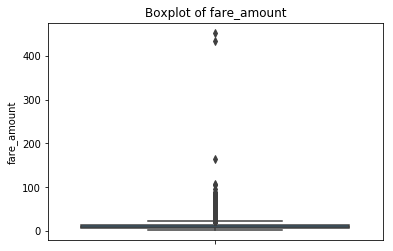

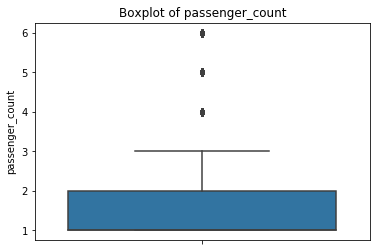

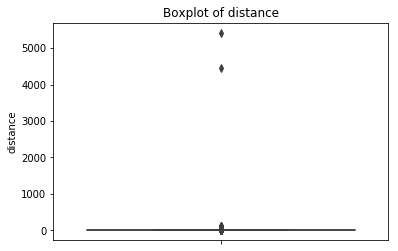

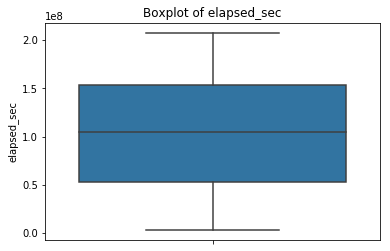

In [2916]:
for i in train_df.columns:
    sns.boxplot(y=train_df[i])
    plt.title("Boxplot of "+i)
    plt.show()

In [2917]:
train_df.columns

Index(['fare_amount', 'passenger_count', 'distance', 'elapsed_sec'], dtype='object')

#### as we can see that there are outliers present

In [2918]:
df = train_df.copy()

for var in ['fare_amount','distance', 'elapsed_sec']: # since the passenger count ranges from 1-6 and is fixed we will not consider it in outliers 
    #Detect and replace with NA
    #Extract quartiles
    q75, q25 = np.percentile(train_df[var], [75 ,25])
    #Calculate IQR
    iqr = q75 - q25
    # #Calculate inner and outer fence
    minimum = q25 - (iqr*1.5)
    maximum = q75 + (iqr*1.5)
     # #Replace with NA
    train_df.loc[train_df[var] < minimum,var] = np.nan
    train_df.loc[train_df[var] > maximum,var] = np.nan
    
# Calculate missing value
missing_val = pd.DataFrame(train_df.isnull().sum())
missing_val

,0
fare_amount,1342
passenger_count,0
distance,1333
elapsed_sec,0


In [2919]:
clean_train_df = pd.DataFrame(KNN(k = 3).fit_transform(train_df), columns=train_df.columns,index=train_df.index)

Imputing row 1/15421 with 0 missing, elapsed time: 65.815
Imputing row 101/15421 with 0 missing, elapsed time: 65.819
Imputing row 201/15421 with 0 missing, elapsed time: 65.824
Imputing row 301/15421 with 0 missing, elapsed time: 65.828
Imputing row 401/15421 with 0 missing, elapsed time: 65.832
Imputing row 501/15421 with 0 missing, elapsed time: 65.838
Imputing row 601/15421 with 0 missing, elapsed time: 65.842
Imputing row 701/15421 with 0 missing, elapsed time: 65.848
Imputing row 801/15421 with 1 missing, elapsed time: 65.854
Imputing row 901/15421 with 0 missing, elapsed time: 65.857
Imputing row 1001/15421 with 0 missing, elapsed time: 65.861
Imputing row 1101/15421 with 0 missing, elapsed time: 65.866
Imputing row 1201/15421 with 0 missing, elapsed time: 65.869
Imputing row 1301/15421 with 0 missing, elapsed time: 65.873
Imputing row 1401/15421 with 0 missing, elapsed time: 65.877
Imputing row 1501/15421 with 0 missing, elapsed time: 65.881
Imputing row 1601/15421 with 0 missi

Imputing row 13501/15421 with 0 missing, elapsed time: 66.371
Imputing row 13601/15421 with 0 missing, elapsed time: 66.376
Imputing row 13701/15421 with 0 missing, elapsed time: 66.379
Imputing row 13801/15421 with 0 missing, elapsed time: 66.385
Imputing row 13901/15421 with 0 missing, elapsed time: 66.387
Imputing row 14001/15421 with 0 missing, elapsed time: 66.393
Imputing row 14101/15421 with 0 missing, elapsed time: 66.396
Imputing row 14201/15421 with 0 missing, elapsed time: 66.399
Imputing row 14301/15421 with 0 missing, elapsed time: 66.402
Imputing row 14401/15421 with 0 missing, elapsed time: 66.407
Imputing row 14501/15421 with 0 missing, elapsed time: 66.414
Imputing row 14601/15421 with 0 missing, elapsed time: 66.418
Imputing row 14701/15421 with 0 missing, elapsed time: 66.422
Imputing row 14801/15421 with 1 missing, elapsed time: 66.426
Imputing row 14901/15421 with 0 missing, elapsed time: 66.429
Imputing row 15001/15421 with 0 missing, elapsed time: 66.434
Imputing

In [2920]:
clean_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15421 entries, 0 to 15420
Data columns (total 4 columns):
fare_amount        15421 non-null float64
passenger_count    15421 non-null float64
distance           15421 non-null float64
elapsed_sec        15421 non-null float64
dtypes: float64(4)
memory usage: 482.0 KB


In [2921]:
clean_train_df.passenger_count = clean_train_df.passenger_count.astype('int64')

In [2922]:
clean_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15421 entries, 0 to 15420
Data columns (total 4 columns):
fare_amount        15421 non-null float64
passenger_count    15421 non-null int64
distance           15421 non-null float64
elapsed_sec        15421 non-null float64
dtypes: float64(3), int64(1)
memory usage: 482.0 KB


In [2923]:
clean_train_df.isnull().sum()

fare_amount        0
passenger_count    0
distance           0
elapsed_sec        0
dtype: int64

# Data Visualization

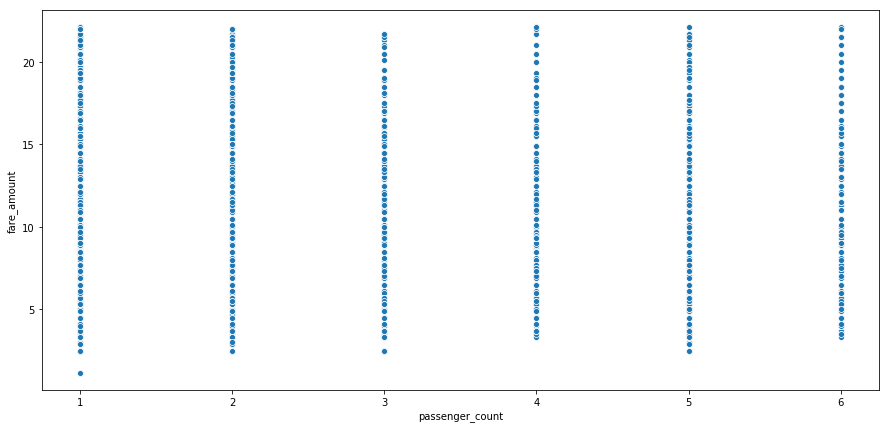

In [2924]:
#Realationship bwetween passenger_count and fare_amount
plt.figure(figsize=(15,7))
sns.scatterplot(x=train_df['passenger_count'],y=train_df['fare_amount'])

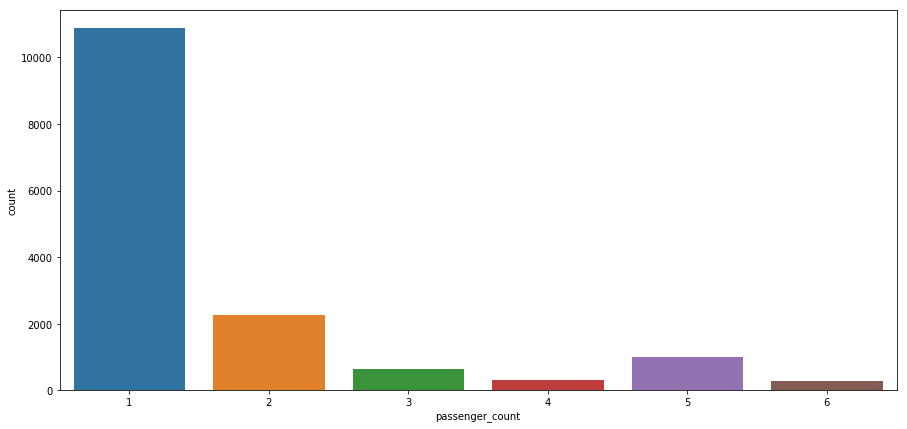

In [2925]:
# Count plot on passenger count
plt.figure(figsize=(15,7))
sns.countplot(x="passenger_count", data=clean_train_df)

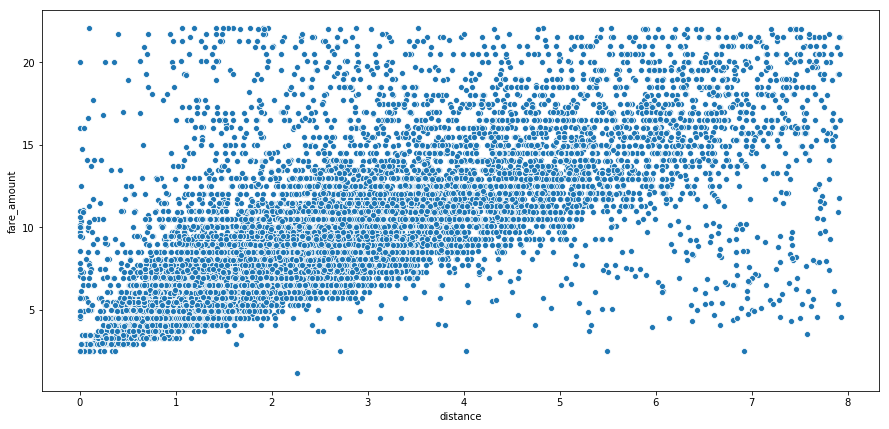

In [2926]:
#check Relationship bewteen fare_amount and distance
plt.figure(figsize=(15,7))
sns.scatterplot(y=clean_train_df['fare_amount'],x=clean_train_df['distance'])

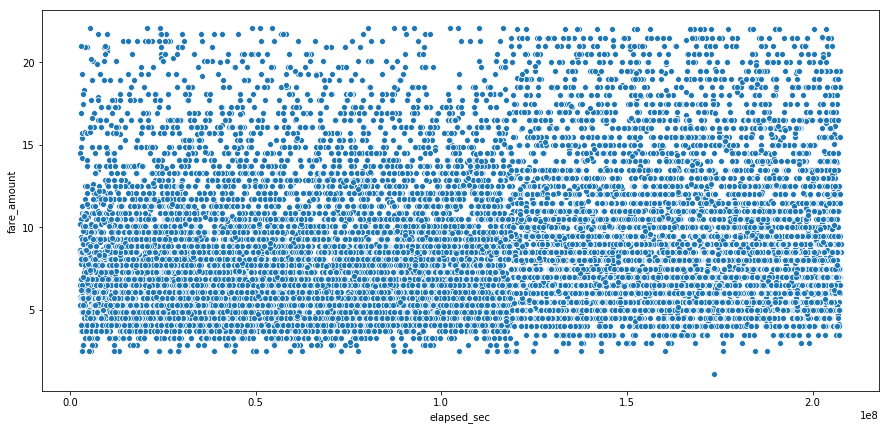

In [2927]:
#check Realtionship between fare_amount and elapsed_sec
plt.figure(figsize=(15,7))
sns.scatterplot(y=clean_train_df['fare_amount'],x=clean_train_df['elapsed_sec'])
               

# Feature Selection

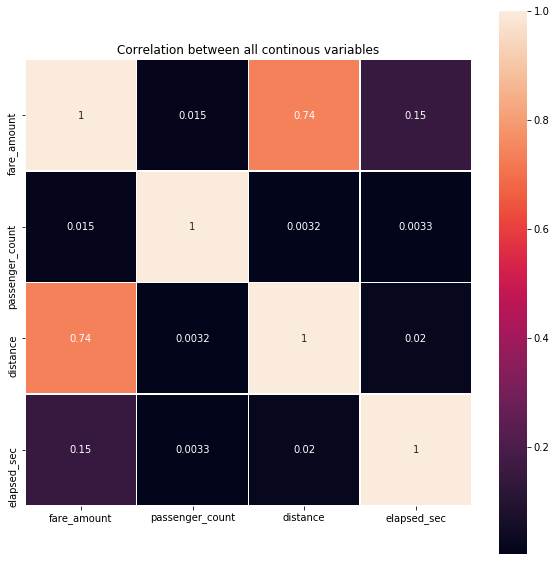

In [2928]:
#plot the heat map to check correlation
df_corr = clean_train_df.copy()
f, ax = plt.subplots(figsize=(10,10))
corr = df_corr.corr()
sns.heatmap(data=corr,annot=True,square=True,linewidths=0.5,linecolor='w')
plt.title("Correlation between all continous variables")
plt.show()

#### Weak positive correlation would be in the range of 0.1 to 0.3, moderate positive correlation from 0.3 to 0.5, and strong positive correlation from 0.5 to 1.0.

# Feature Scaling

In [2929]:
clean_train_df.describe() #check min max and std before feature scaling

,fare_amount,passenger_count,distance,elapsed_sec
count,15421.000000,15421.000000,15421.000000,1.542100e+04
mean,8.948871,1.652163,2.466813,1.041625e+08
std,4.076201,1.267784,1.639679,5.864895e+07
min,1.140000,1.000000,0.000202,2.678400e+06
25%,6.000000,1.000000,1.236875,5.303691e+07
50%,8.000000,1.000000,2.023432,1.043291e+08
75%,11.000000,2.000000,3.268998,1.537458e+08
max,22.100000,6.000000,7.929039,2.076090e+08


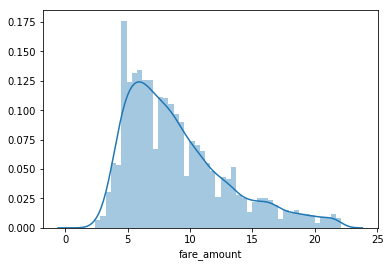

In [2930]:
#Normality check
sns.distplot(clean_train_df['fare_amount'])

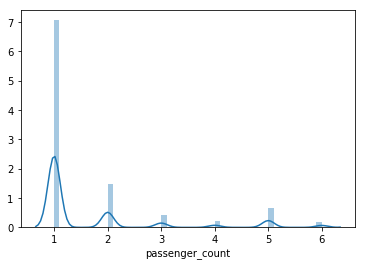

In [2931]:
sns.distplot(clean_train_df['passenger_count'])

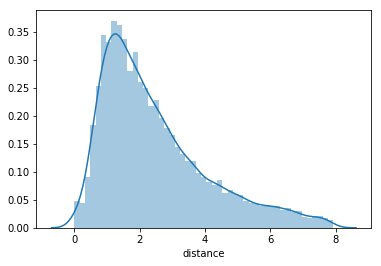

In [2932]:
sns.distplot(clean_train_df['distance'])

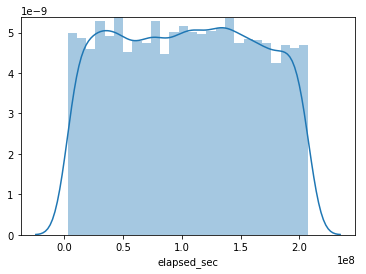

In [2933]:
sns.distplot(clean_train_df['elapsed_sec'])

In [2934]:
#Lets normalize 
clean_train_df['elapsed_sec'] = (clean_train_df['elapsed_sec'] - min(clean_train_df['elapsed_sec']))/(max(clean_train_df['elapsed_sec']) - min(clean_train_df['elapsed_sec']))

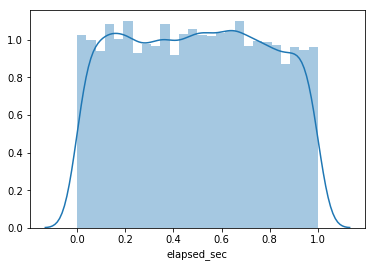

In [2935]:
sns.distplot(clean_train_df['elapsed_sec'])

In [2936]:
#Lets check the skweness
for var in clean_train_df.columns:
        print("Skewness of", var , ": ",clean_train_df[var].skew(),"\n")
    

Skewness of fare_amount :  1.025278015372948 

Skewness of passenger_count :  2.0712905923822933 

Skewness of distance :  1.1126410119951426 

Skewness of elapsed_sec :  0.012727027937341207 



### The rule of thumb seems to be:
    1.If skewness is less than -1 or greater than 1, the distribution is highly skewed.
    2.If skewness is between -1 and -0.5 or between 0.5 and 1, the distribution is moderately skewed.
    3.If skewness is between -0.5 and 0.5, the distribution is approximately symmetric.
    
The skewness for a normal distribution is zero, and any symmetric data should have a skewness near zero. Negative values for the skewness indicate data that are skewed left and positive values for the skewness indicate data that are skewed right.

In [2937]:
clean_train_df.passenger_count = clean_train_df.passenger_count.astype('category')

In [2938]:
#since skewness of target variable is high, apply log transform to reduce the skewness-
clean_train_df['fare_amount'] = np.log1p(clean_train_df['fare_amount'])
#since skewness of distance variable is high, apply log transform to reduce the skewness-
clean_train_df['distance'] = np.log1p(clean_train_df['distance'])

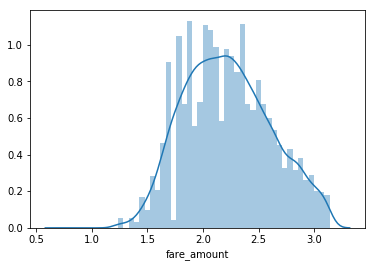

In [2939]:
sns.distplot(clean_train_df['fare_amount'])

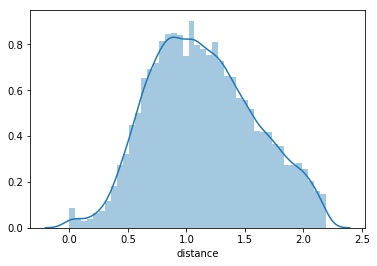

In [2940]:
sns.distplot(clean_train_df['distance'])

In [2941]:
for var in ['fare_amount','distance']:
        print("Skewness of", var , ": ",clean_train_df[var].skew(),"\n")

#All good now

Skewness of fare_amount :  0.21527327089853524 

Skewness of distance :  0.20009538679423 



In [2942]:
# we have to do the same transformation on test data
test_df['elapsed_sec'] = (test_df['elapsed_sec'] - min(test_df['elapsed_sec']))/(max(test_df['elapsed_sec']) - min(test_df['elapsed_sec']))

In [2943]:
test_df['distance'] = np.log1p(test_df['distance'])

In [2944]:
test_df.describe()

,passenger_count,distance,elapsed_sec
count,9914.000000,9914.000000,9914.000000
mean,1.671273,1.270879,0.514862
std,1.278747,0.610763,0.272658
min,1.000000,0.000000,0.000000
25%,1.000000,0.832160,0.289004
50%,1.000000,1.168577,0.472238
75%,2.000000,1.618457,0.774353
max,6.000000,4.615081,1.000000


In [2945]:
clean_train_df.describe()

,fare_amount,distance,elapsed_sec
count,15421.000000,15421.000000,15421.000000
mean,2.220140,1.141313,0.495212
std,0.389373,0.447178,0.286189
min,0.760806,0.000202,0.000000
25%,1.945910,0.805080,0.245734
50%,2.197225,1.106393,0.496025
75%,2.484907,1.451379,0.737164
max,3.139833,2.189309,1.000000


# Splitting data into train and test

In [2946]:
clean_train, clean_test = train_test_split(clean_train_df, test_size=0.2)

In [2947]:
clean_train.head()

,fare_amount,passenger_count,distance,elapsed_sec
2021,1.629241,1,0.561368,0.197660
10849,2.602690,1,1.763130,0.659324
2096,2.292535,1,1.521149,0.211563
8636,1.458615,1,0.417275,0.118242
12604,2.163323,1,1.285920,0.301639


In [2948]:
clean_train.shape

(12336, 4)

In [2949]:
clean_test.head()

,fare_amount,passenger_count,distance,elapsed_sec
11135,3.104587,1,0.677372,0.512404
3833,1.840550,1,1.004427,0.527542
7042,2.014903,1,1.156459,0.075033
2962,2.208274,1,1.227251,0.481021
2136,2.116256,1,0.483426,0.285250


In [2950]:
clean_test.shape

(3085, 4)

In [2951]:
clean_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12336 entries, 2021 to 4998
Data columns (total 4 columns):
fare_amount        12336 non-null float64
passenger_count    12336 non-null category
distance           12336 non-null float64
elapsed_sec        12336 non-null float64
dtypes: category(1), float64(3)
memory usage: 397.8 KB


In [2952]:
clean_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3085 entries, 11135 to 5860
Data columns (total 4 columns):
fare_amount        3085 non-null float64
passenger_count    3085 non-null category
distance           3085 non-null float64
elapsed_sec        3085 non-null float64
dtypes: category(1), float64(3)
memory usage: 99.6 KB


In [2953]:
train_feature_variables = clean_train.copy().drop(columns=['fare_amount'])
train_target_variable = pd.DataFrame(clean_train['fare_amount'])

test_feature_variables = clean_test.copy().drop(columns=['fare_amount'])
test_target_variable = pd.DataFrame(clean_test['fare_amount'])

In [2954]:
train_feature_variables.head()

,passenger_count,distance,elapsed_sec
2021,1,0.561368,0.197660
10849,1,1.763130,0.659324
2096,1,1.521149,0.211563
8636,1,0.417275,0.118242
12604,1,1.285920,0.301639


In [2955]:
test_feature_variables.head()

,passenger_count,distance,elapsed_sec
11135,1,0.677372,0.512404
3833,1,1.004427,0.527542
7042,1,1.156459,0.075033
2962,1,1.227251,0.481021
2136,1,0.483426,0.285250


In [2956]:
train_target_variable.head()

,fare_amount
2021,1.629241
10849,2.602690
2096,2.292535
8636,1.458615
12604,2.163323


In [2957]:
test_target_variable.head()

,fare_amount
11135,3.104587
3833,1.840550
7042,2.014903
2962,2.208274
2136,2.116256


# Model Development

In [2958]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

### Linear Regression

In [2959]:
#Building Linear Regression model
LR_model = LinearRegression().fit(train_feature_variables, train_target_variables)

In [2960]:
prediction = LR_model.predict(test_feature_variables)

In [2961]:
#calculate Error metrics on test data
print("R2 Score:",r2_score(test_target_variable,prediction))
print("Mean Absolute Error:",mean_absolute_error(test_target_variable,prediction))
print("Mean Squared Error:",mean_squared_error(test_target_variable,prediction))
print("Root Mean Squared Error:",np.sqrt(mean_squared_error(test_target_variable,prediction)))
print("MAPE:",mean_absolute_percentage_error(test_target_variable,prediction))
print("Accuracy:",(100 - mean_absolute_percentage_error(test_target_variable,prediction)))

R2 Score: 0.0048132984386068944
Mean Absolute Error: 0.3196589020711661
Mean Squared Error: 0.15106700376826834
Root Mean Squared Error: 0.38867338958085146
MAPE: fare_amount    14.899055
dtype: float64
Accuracy: fare_amount    85.100945
dtype: float64


In [2962]:
#calculate error metrics on training data
pred = LR_model.predict(train_feature_variables)
print("R2 Score:",r2_score(train_target_variable,pred))
print("Mean Absolute Error:",mean_absolute_error(train_target_variable,pred))
print("Mean Squared Error:",mean_squared_error(train_target_variable,pred))
print("Root Mean Squared Error:",np.sqrt(mean_squared_error(train_target_variable,pred)))
print("MAPE:",mean_absolute_percentage_error(train_target_variable,pred))
print("Accuracy:",(100 - mean_absolute_percentage_error(train_target_variable,pred)))

R2 Score: 0.0049235739704570625
Mean Absolute Error: 0.31823981055871803
Mean Squared Error: 0.15080499696001293
Root Mean Squared Error: 0.3883361906390041
MAPE: fare_amount    14.945792
dtype: float64
Accuracy: fare_amount    85.054208
dtype: float64


### Decision Tree Model

In [2963]:
DT_model = DecisionTreeRegressor(max_depth=2).fit(train_feature_variables,train_target_variable)

In [2964]:
prediction = DT_model.predict(test_feature_variables)

In [2965]:
prediction = prediction.reshape((3085,1))

In [2966]:
#calculate Error metrics on test data
print("R2 Score:",r2_score(test_target_variable,prediction))
print("Mean Absolute Error:",mean_absolute_error(test_target_variable,prediction))
print("Mean Squared Error:",mean_squared_error(test_target_variable,prediction))
print("Root Mean Squared Error:",np.sqrt(mean_squared_error(test_target_variable,prediction)))
print("MAPE:",mean_absolute_percentage_error(test_target_variable,prediction))
print("Accuracy:",(100 - mean_absolute_percentage_error(test_target_variable,prediction)))

R2 Score: 0.56502904032977
Mean Absolute Error: 0.19290872262939546
Mean Squared Error: 0.06602757000319132
Root Mean Squared Error: 0.25695830401680214
MAPE: fare_amount    8.780484
dtype: float64
Accuracy: fare_amount    91.219516
dtype: float64


In [2967]:
#calculate error metrics on training data
pred = DT_model.predict(train_feature_variables)
pred = pred.reshape((12336,1))
print("R2 Score:",r2_score(train_target_variable,pred))
print("Mean Absolute Error:",mean_absolute_error(train_target_variable,pred))
print("Mean Squared Error:",mean_squared_error(train_target_variable,pred))
print("Root Mean Squared Error:",np.sqrt(mean_squared_error(train_target_variable,pred)))
print("MAPE:",mean_absolute_percentage_error(train_target_variable,pred))
print("Accuracy:",(100 - mean_absolute_percentage_error(train_target_variable,pred)))

R2 Score: 0.5715380454854317
Mean Absolute Error: 0.19210413482091365
Mean Squared Error: 0.0649339106603781
Root Mean Squared Error: 0.25482133085826647
MAPE: fare_amount    8.808789
dtype: float64
Accuracy: fare_amount    91.191211
dtype: float64


### Random Forest

In [2968]:
RF_model = RandomForestRegressor(n_estimators = 200).fit(train_feature_variables,train_target_variable.values.ravel())


In [2969]:
prediction = RF_model.predict(test_feature_variables)

In [2970]:
prediction = prediction.reshape((3085,1))

In [2971]:
#calculate Error metrics on test data
print("R2 Score:",r2_score(test_target_variable,prediction))
print("Mean Absolute Error:",mean_absolute_error(test_target_variable,prediction))
print("Mean Squared Error:",mean_squared_error(test_target_variable,prediction))
print("Root Mean Squared Error:",np.sqrt(mean_squared_error(test_target_variable,prediction)))
print("MAPE:",mean_absolute_percentage_error(test_target_variable,prediction))
print("Accuracy:",(100 - mean_absolute_percentage_error(test_target_variable,prediction)))

R2 Score: 0.5965764851516375
Mean Absolute Error: 0.18113399117552217
Mean Squared Error: 0.06123874197895518
Root Mean Squared Error: 0.24746462773284422
MAPE: fare_amount    8.272189
dtype: float64
Accuracy: fare_amount    91.727811
dtype: float64


In [2972]:
#calculate error metrics on training data
pred = RF_model.predict(train_feature_variables)
pred = pred.reshape((12336,1))
print("R2 Score:",r2_score(train_target_variable,pred))
print("Mean Absolute Error:",mean_absolute_error(train_target_variable,pred))
print("Mean Squared Error:",mean_squared_error(train_target_variable,pred))
print("Root Mean Squared Error:",np.sqrt(mean_squared_error(train_target_variable,pred)))
print("MAPE:",mean_absolute_percentage_error(train_target_variable,pred))
print("Accuracy:",(100 - mean_absolute_percentage_error(train_target_variable,pred)))

R2 Score: 0.94372054998546
Mean Absolute Error: 0.06661349278136668
Mean Squared Error: 0.008529216516784349
Root Mean Squared Error: 0.09235375745893801
MAPE: fare_amount    3.058588
dtype: float64
Accuracy: fare_amount    96.941412
dtype: float64


### XGBoost

In [2973]:
clean_train_df.head()

,fare_amount,passenger_count,distance,elapsed_sec
0,1.704748,1,0.708412,0.069844
1,2.884801,1,1.880662,0.155842
2,1.902108,2,0.871095,0.404304
3,2.163323,1,1.334809,0.508509
4,1.840550,1,1.098331,0.182245


In [2974]:
X = clean_train_df.drop(columns=['fare_amount'])
y = clean_train_df['fare_amount'].values
X['passenger_count'] = X['passenger_count'].astype('int64')
train_feature_variables.passenger_count = train_feature_variables.astype('int64')
test_feature_variables.passenger_count = test_feature_variables.astype('int64')

In [2975]:
X.head()

,passenger_count,distance,elapsed_sec
0,1,0.708412,0.069844
1,1,1.880662,0.155842
2,2,0.871095,0.404304
3,1,1.334809,0.508509
4,1,1.098331,0.182245


In [2976]:
y

array([1.70474809, 2.88480071, 1.90210753, ..., 2.83907846, 2.2512918 ,
       2.20827441])

In [2977]:
data_dmatrix = xgb.DMatrix(data=X,label=y)
dtrain = xgb.DMatrix(train_feature_variables, label=train_target_variable)
dtest = xgb.DMatrix(test_feature_variables)

In [2978]:
params = {"objective":"reg:linear",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=5,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)
cv_results.head()

[10:57:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[10:57:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[10:57:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[10:57:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[10:57:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.


,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,1.596429,0.001350,1.596420,0.006158
1,1.445695,0.001751,1.445848,0.007403
2,1.309702,0.003670,1.309994,0.009272
3,1.188753,0.003617,1.188992,0.010216
4,1.079354,0.004202,1.079628,0.010355


In [2979]:
# the final boosting round metric
print((cv_results["test-rmse-mean"]).tail(1))

49    0.245042
Name: test-rmse-mean, dtype: float64


In [2980]:
Xgb = XGBRegressor()
Xgb.fit(train_feature_variables,train_target_variables)

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)

In [2981]:
prediction = Xgb.predict(test_feature_variables)

In [2982]:
prediction = prediction.reshape((3085,1))

In [2983]:
#calculate Error metrics on test data
print("R2 Score:",r2_score(test_target_variable,prediction))
print("Mean Absolute Error:",mean_absolute_error(test_target_variable,prediction))
print("Mean Squared Error:",mean_squared_error(test_target_variable,prediction))
print("Root Mean Squared Error:",np.sqrt(mean_squared_error(test_target_variable,prediction)))
print("MAPE:",mean_absolute_percentage_error(test_target_variable,prediction))
print("Accuracy:",(100 - mean_absolute_percentage_error(test_target_variable,prediction)))

R2 Score: -0.04793815632280518
Mean Absolute Error: 0.32567495939846985
Mean Squared Error: 0.15907455069661952
Root Mean Squared Error: 0.3988415107490938
MAPE: fare_amount    15.148469
dtype: float64
Accuracy: fare_amount    84.851531
dtype: float64


In [2984]:
#calculate error metrics on training data
pred = Xgb.predict(train_feature_variables)
pred = pred.reshape((12336,1))
print("R2 Score:",r2_score(train_target_variable,pred))
print("Mean Absolute Error:",mean_absolute_error(train_target_variable,pred))
print("Mean Squared Error:",mean_squared_error(train_target_variable,pred))
print("Root Mean Squared Error:",np.sqrt(mean_squared_error(train_target_variable,pred)))
print("MAPE:",mean_absolute_percentage_error(train_target_variable,pred))
print("Accuracy:",(100 - mean_absolute_percentage_error(train_target_variable,pred)))

R2 Score: -0.0808877572062261
Mean Absolute Error: 0.32752024573672067
Mean Squared Error: 0.16380980462978098
Root Mean Squared Error: 0.4047342395075823
MAPE: fare_amount    15.366815
dtype: float64
Accuracy: fare_amount    84.633185
dtype: float64


In [2985]:
# Create the random grid
para = {'n_estimators': range(100,500,100),
               'max_depth': range(3,10,1),
        'reg_alpha':np.logspace(-4, 0, 50),
        'subsample': np.arange(0.1,1,0.2),
        'colsample_bytree': np.arange(0.1,1,0.2),
        'colsample_bylevel': np.arange(0.1,1,0.2),
        'colsample_bynode': np.arange(0.1,1,0.2),
       'learning_rate': np.arange(.05, 1, .05)}
# Instantiate a Decision Forest classifier: Forest
Xgb = XGBRegressor()

# Instantiate the gridSearchCV object: Forest_cv
xgb_cv = RandomizedSearchCV(Xgb, para, cv=5)

xgb_cv.fit(X,y)
print("Tuned Xgboost Parameters: {}".format(xgb_cv.best_params_))
print("Best score is {}".format(xgb_cv.best_score_))

Tuned Xgboost Parameters: {'subsample': 0.30000000000000004, 'reg_alpha': 0.013257113655901081, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.5000000000000001, 'colsample_bynode': 0.5000000000000001, 'colsample_bylevel': 0.1}
Best score is 0.6299374738481539


In [2986]:
Xgb = XGBRegressor(subsample=0.30000000000000004,reg_alpha=0.013257113655901081,n_estimators=300,max_depth=3,learning_rate=0.1,colsample_bytree=0.5000000000000001,colsample_bynode=0.5000000000000001,colsample_bylevel=0.1)

In [2987]:
# Fit the regressor to the data
Xgb.fit(train_feature_variables,train_target_variable)

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=0.1,
             colsample_bynode=0.5000000000000001,
             colsample_bytree=0.5000000000000001, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=300, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0,
             reg_alpha=0.013257113655901081, reg_lambda=1, scale_pos_weight=1,
             subsample=0.30000000000000004, tree_method=None,
             validate_parameters=False, verbosity=None)

In [2988]:
prediction = Xgb.predict(test_feature_variables)

In [2989]:
prediction = prediction.reshape((3085,1))

In [2990]:
#calculate Error metrics on test data
print("R2 Score:",r2_score(test_target_variable,prediction))
print("Mean Absolute Error:",mean_absolute_error(test_target_variable,prediction))
print("Mean Squared Error:",mean_squared_error(test_target_variable,prediction))
print("Root Mean Squared Error:",np.sqrt(mean_squared_error(test_target_variable,prediction)))
print("MAPE:",mean_absolute_percentage_error(test_target_variable,prediction))
print("Accuracy:",(100 - mean_absolute_percentage_error(test_target_variable,prediction)))

R2 Score: 0.6405187604035649
Mean Absolute Error: 0.16716349710968018
Mean Squared Error: 0.05456840780883999
Root Mean Squared Error: 0.2335988180809997
MAPE: fare_amount    7.61149
dtype: float64
Accuracy: fare_amount    92.38851
dtype: float64


In [2991]:
#calculate error metrics on training data
pred = Xgb.predict(train_feature_variables)
pred = pred.reshape((12336,1))
print("R2 Score:",r2_score(train_target_variable,pred))
print("Mean Absolute Error:",mean_absolute_error(train_target_variable,pred))
print("Mean Squared Error:",mean_squared_error(train_target_variable,pred))
print("Root Mean Squared Error:",np.sqrt(mean_squared_error(train_target_variable,pred)))
print("MAPE:",mean_absolute_percentage_error(train_target_variable,pred))
print("Accuracy:",(100 - mean_absolute_percentage_error(train_target_variable,pred)))

R2 Score: 0.6573791917552663
Mean Absolute Error: 0.16362746296163236
Mean Squared Error: 0.05192458447834865
Root Mean Squared Error: 0.22786966555105279
MAPE: fare_amount    7.485074
dtype: float64
Accuracy: fare_amount    92.514926
dtype: float64


### As we can see that Xgboost is the best algorithm for our problem.

# Prediction of fare from provided test dataset :

In [2992]:
test_df.head()

,passenger_count,distance,elapsed_sec
0,1,1.200946,0.934937
1,1,1.231205,0.934937
2,1,0.481579,0.425928
3,1,1.085538,0.603204
4,1,1.854312,0.603204


In [2993]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9914 entries, 0 to 9913
Data columns (total 3 columns):
passenger_count    9914 non-null int64
distance           9914 non-null float64
elapsed_sec        9914 non-null float64
dtypes: float64(2), int64(1)
memory usage: 232.4 KB


In [2994]:
test_pred = Xgb.predict(test_df)

In [2995]:
test_df.to_csv('test_result.csv')